In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
#from skimage.util.montage import montage2d as montage
path = "/mnt/3CE35B99003D727B/input/kaggle/Airbus Ship Detection Challenge/"


import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"


train = pd.read_csv(os.path.join(path + 'train_ship_segmentations_v2.csv'))

print(train.shape[0],'masks found')

train.head()

231723 masks found


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.util import montage2d as montage
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ship_dir = path
train_image_dir = os.path.join(ship_dir, 'train_v2')
test_image_dir = os.path.join(ship_dir, 'test_v2')
import gc; gc.enable() # memory is tight

from skimage.morphology import label
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

In [5]:
from keras import models, layers
fullres_model = models.load_model(path + '/models/fullres_model_unet34.h5', compile=False)
seg_in_shape = fullres_model.get_input_shape_at(0)[1:3]
seg_out_shape = fullres_model.get_output_shape_at(0)[1:3]
print(seg_in_shape, '->', seg_out_shape)

(None, None) -> (None, None)


In [7]:
fullres_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
average_pooling2d_1 (Average (None, None, None, 3)     0         
_________________________________________________________________
u-resnet34 (Model)           multiple                  24453178  
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, None, None, 1)     0         
Total params: 24,453,178
Trainable params: 24,437,812
Non-trainable params: 15,366
_________________________________________________________________


# Plot Test Image by part-2 trained model¶


In [9]:
test_paths = os.listdir(test_image_dir)
print(len(test_paths), 'test images found')

15606 test images found


InvalidArgumentError:  Size 1 must be non-negative, not -21
	 [[{{node u-resnet34_1/bn_data/batchnorm/mul-1-ReshapeNHWCToNCHW-LayoutOptimizer}}]] [Op:__inference_keras_scratch_graph_19489]

Function call stack:
keras_scratch_graph


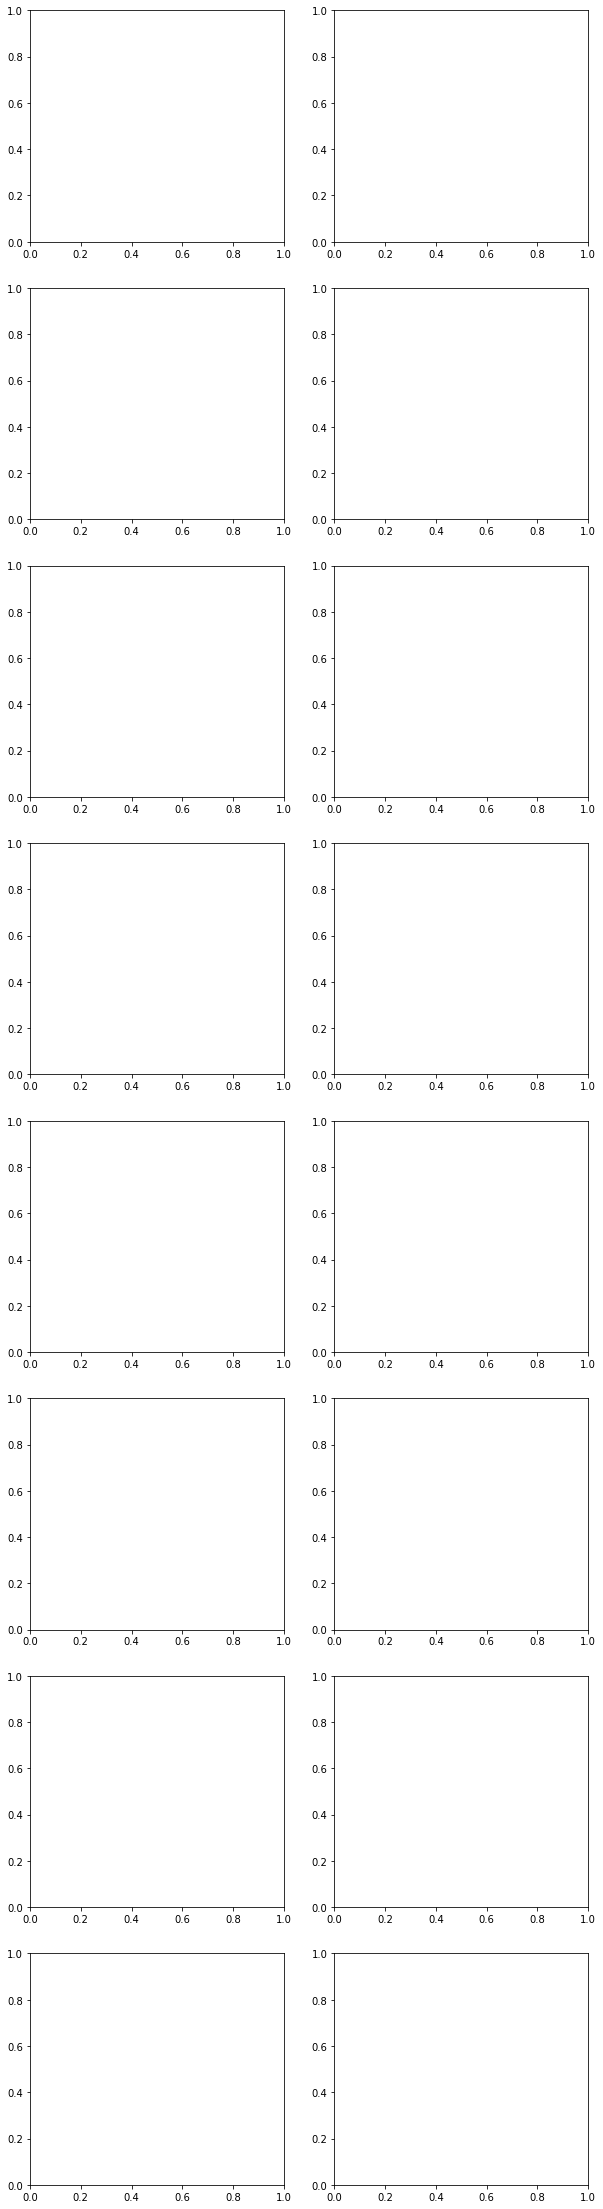

In [10]:
fig, m_axs = plt.subplots(8, 2, figsize = (10, 40))
for (ax1, ax2), c_img_name in zip(m_axs, test_paths):
    c_path = os.path.join(test_image_dir, c_img_name)
    c_img = imread(c_path)
    first_img = np.expand_dims(c_img, 0)/255.0
    first_seg = fullres_model.predict(first_img)
    ax1.imshow(first_img[0])
    ax1.set_title(c_img_name)
    ax2.imshow(first_seg[0, :, :, 0], vmin = 0, vmax = 1)
    ax2.set_title('Prediction')
fig.savefig('test_predictions.png')

In [12]:
have_ship= pd.read_csv("Have_ship_or_not.csv")

In [13]:
have_ship

,ImageId,Have_ship
0,00002bd58.jpg,0
1,00015efb6.jpg,0
2,00023d5fc.jpg,0
3,000367c13.jpg,0
4,0008ca6e9.jpg,0
...,...,...
15601,a6d79384e.jpg,1
15602,a6ddd0cfa.jpg,0
15603,a6e7f8433.jpg,0
15604,a6ea86ea0.jpg,0


In [14]:
test_names = have_ship.loc[have_ship['Have_ship'] > 0.5, ['ImageId']]['ImageId'].values.tolist()
test_names_nothing = have_ship.loc[have_ship['Have_ship'] <= 0.5, ['ImageId']]['ImageId'].values.tolist()
len(test_names), len(test_names_nothing)

(4426, 11180)

# No ship data to submission file¶


In [17]:
ship_list_dict = []
for name in test_names_nothing:
    ship_list_dict.append({'ImageId':name,'EncodedPixels':None})

In [18]:
from tqdm import tqdm_notebook
from skimage.morphology import binary_opening, disk
for c_img_name in tqdm_notebook(test_paths):
    if c_img_name in test_names:
        c_path = os.path.join(test_image_dir, c_img_name)
        c_img = imread(c_path)
        c_img = np.expand_dims(c_img, 0)/255.0
        cur_seg = fullres_model.predict(c_img)[0]
        cur_seg = binary_opening(cur_seg>0.5, np.expand_dims(disk(2), -1))
        cur_rles = multi_rle_encode(cur_seg)
        if len(cur_rles)>0:
            for c_rle in cur_rles:
                ship_list_dict += [{'ImageId': c_img_name, 'EncodedPixels': c_rle}]
        else:
            ship_list_dict += [{'ImageId': c_img_name, 'EncodedPixels': None}]
    gc.collect()
    

/home/jake/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


InvalidArgumentError:  Size 1 must be non-negative, not -21
	 [[{{node u-resnet34_1/bn_data/batchnorm/mul-1-ReshapeNHWCToNCHW-LayoutOptimizer}}]] [Op:__inference_keras_scratch_graph_19489]

Function call stack:
keras_scratch_graph
